In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import layers, models, regularizers, optimizers, ops, callbacks

import pandas as pd
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
import math

import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
from datasets import load_dataset

ds = load_dataset("imdb")
df = pd.DataFrame(ds['train']) # Convert the train portion to pandas format
test_df = pd.DataFrame(ds['test']) # Convert the test portion to pandas format

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/tmp/ipython-input-2452013462.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


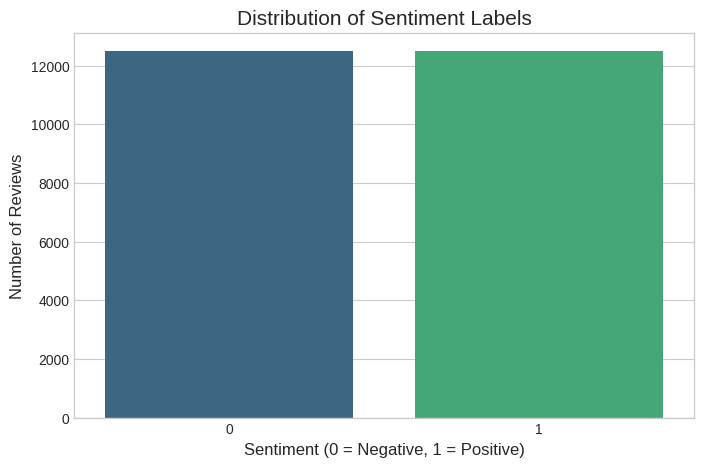

In [2]:
# Class distribution, sentiment balance

plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')

plt.title('Distribution of Sentiment Labels', fontsize=15)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

In [3]:
# Remove potential noise in data, remove HTML syntax which can inflate word length
df['text'] = df['text'].str.replace('<br />', ' ', regex=False)

test_df['text'] = test_df['text'].str.replace('<br />', ' ', regex=False)

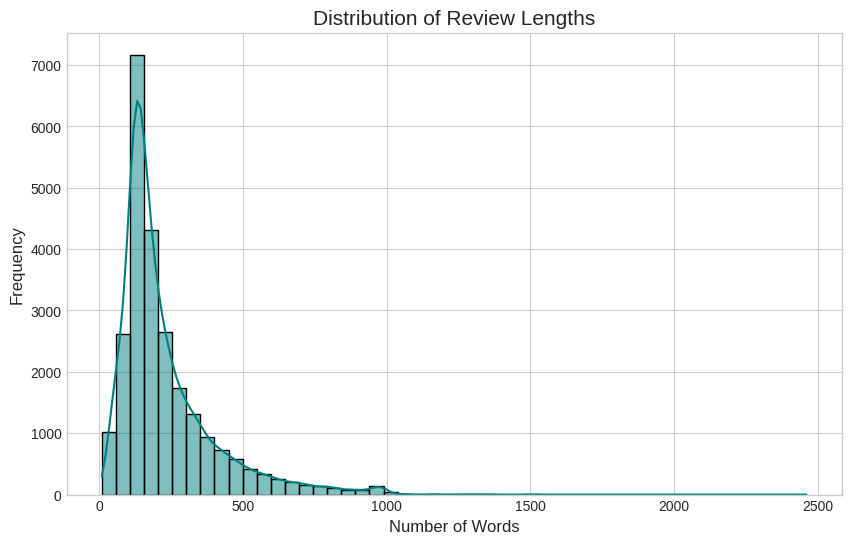

In [4]:
# Create a new column for the number of words in each review
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True, color='teal')

plt.title('Distribution of Review Lengths', fontsize=15)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

In [5]:
perc_90 = df['review_length'].quantile(0.90)

print(f"90% of reviews are {perc_90:.0f} words or shorter.")

# To see a broader range:
print(f"75th percentile: {df['review_length'].quantile(0.75):.0f}")
print(f"95th percentile: {df['review_length'].quantile(0.95):.0f}")
print(f"99th percentile: {df['review_length'].quantile(0.99):.0f}")

90% of reviews are 454 words or shorter.
75th percentile: 281
95th percentile: 592
99th percentile: 907


In [6]:
# Check for missing values
print("Missing Values per Column:")
print(df.isnull().sum())
print(f"\nTotal Missing Values: {df.isnull().sum().sum()}")

# Check for missing values in test set
print("Missing Values per Column in test set:")
print(test_df.isnull().sum())
print(f"\nTotal Missing Values: {test_df.isnull().sum().sum()}")

Missing Values per Column:
text             0
label            0
review_length    0
dtype: int64

Total Missing Values: 0
Missing Values per Column in test set:
text     0
label    0
dtype: int64

Total Missing Values: 0


In [7]:
# Check for Duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicate_count}")

duplicate_count = test_df.duplicated().sum()
print(f"Number of Duplicate Rows in test set: {duplicate_count}")

Number of Duplicate Rows: 96
Number of Duplicate Rows in test set: 199


In [8]:
# Remove the duplicates found
df = df.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)

print(f"Cleaned training set size: {len(df)}")

test_df = test_df.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)

print(f"Cleaned test set size: {len(test_df)}")

Cleaned training set size: 24904
Cleaned test set size: 24801


In [9]:
# Check for 'Empty' strings (text that is just whitespace)
empty_strings = df[df['text'].str.strip() == ""].shape[0]
print(f"Number of Empty Text Strings in training set: {empty_strings}")

empty_strings = test_df[test_df['text'].str.strip() == ""].shape[0]
print(f"Number of Empty Text Strings in test set: {empty_strings}")

Number of Empty Text Strings in training set: 0
Number of Empty Text Strings in test set: 0


Test and training dataset has been checked and cleaned for missing values, duplicate rows, and empty review strings.

In [11]:
# Data augmentation - Synonym replacement

import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger_eng')

aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.1)

def apply_augmentation(text_list):
    print("Augmenting data... this may take a minute.")
    # Returns the original text + one augmented version for every row
    augmented_docs = [aug.augment(text)[0] for text in text_list]
    return augmented_docs

original_texts = df['text'].tolist()
augmented_texts = apply_augmentation(original_texts)

# Create a new combined Training DataFrame
df_final_train = pd.DataFrame({
    'text': original_texts + augmented_texts,
    'label': df['label'].tolist() + df['label'].tolist()
})

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Augmenting data... this may take a minute.


In [12]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = " ".join(text.split())
    return text

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

vocab_size = 20000
maxlen = 500 # Chosen 500 for maxlen based on distribution length

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

In [14]:
# Normalize text
df_final_train['clean_text'] = df_final_train['text'].apply(normalize_text)
test_df['clean_text'] = test_df['text'].apply(normalize_text)

# Tokenize
tokenizer.fit_on_texts(df_final_train['clean_text'])

In [15]:
train_sequences = tokenizer.texts_to_sequences(df_final_train['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])

In [16]:
from keras.utils import pad_sequences
x_train_full = pad_sequences(train_sequences, maxlen, padding='post')
x_test = pad_sequences(test_sequences, maxlen, padding='post')

In [17]:
y_test = y_test = test_df['label'].values

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full,
    df_final_train['label'].values,
    test_size=0.2,
    random_state=42
)

In [19]:
print("--- SHAPE VERIFICATION ---")
print(f"Training rows:   {x_train.shape[0]} | Words per row: {x_train.shape[1]}")
print(f"Validation rows: {x_val.shape[0]} | Words per row: {x_val.shape[1]}")
print(f"Testing rows:    {x_test.shape[0]}  | Words per row: {x_test.shape[1]}")

--- SHAPE VERIFICATION ---
Training rows:   39846 | Words per row: 500
Validation rows: 9962 | Words per row: 500
Testing rows:    24801  | Words per row: 500


In [20]:
print("\n--- FIRST 3 ROWS OF VALIDATION (NUMBERS) ---")
print(x_val[:3])

print("\n--- FIRST 3 LABELS OF VALIDATION (ANSWERS) ---")
print(y_val[:3])


--- FIRST 3 ROWS OF VALIDATION (NUMBERS) ---
[[  2 794  19 ...   0   0   0]
 [ 50   4 636 ...   0   0   0]
 [589 716   4 ...   0   0   0]]

--- FIRST 3 LABELS OF VALIDATION (ANSWERS) ---
[0 0 0]


In [21]:
# Code referenced from https://keras.io/examples/nlp/text_classification_with_transformer/

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
embed_dim = 32
num_heads = 1
ff_dim = 32

inputs = layers.Input(shape=(maxlen,))

x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = layers.GlobalAveragePooling1D()(x)

x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_basic_transformer = keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model_basic_transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [24]:
history_basic_transformer = model_basic_transformer.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(x_val, y_val)
)

Epoch 1/5
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.6853 - loss: 0.5224 - val_accuracy: 0.9157 - val_loss: 0.2169
Epoch 2/5
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9486 - loss: 0.1465 - val_accuracy: 0.9240 - val_loss: 0.2078
Epoch 3/5
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9736 - loss: 0.0801 - val_accuracy: 0.9388 - val_loss: 0.1997
Epoch 4/5
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.9833 - loss: 0.0478 - val_accuracy: 0.9416 - val_loss: 0.1801
Epoch 5/5
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.9920 - loss: 0.0275 - val_accuracy: 0.9448 - val_loss: 0.2158


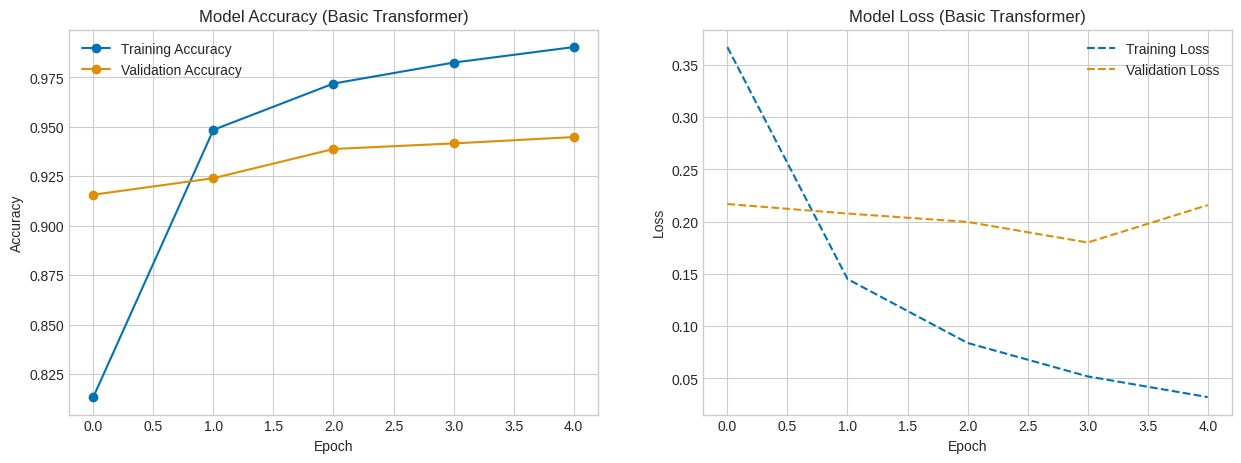

In [25]:
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_basic_transformer.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_basic_transformer.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy (Basic Transformer)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_basic_transformer.history['loss'], label='Training Loss', linestyle='--')
plt.plot(history_basic_transformer.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss (Basic Transformer)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [26]:
# Implement a custom postion encoding, utilize sinusoidal positioning
class SinusoidalPositionalEncoding(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        # x is (batch_size, sequence_length, embedding_dim)
        seq_len = ops.shape(x)[1]
        embed_dim = ops.shape(x)[2]

        # Generate the position indices (0, 1, 2, ..., maxlen)
        position = ops.reshape(ops.arange(seq_len, dtype="float32"), (seq_len, 1))

        # Calculate the division term for the frequencies
        div_term = ops.exp(
            ops.arange(0, embed_dim, 2, dtype="float32") * -(np.log(10000.0) / embed_dim)
        )

        # Create the Sine and Cosine patterns
        # Apply Sine to even indices and Cosine to odd indices
        pos_encoding = ops.concatenate([
            ops.sin(position * div_term),
            ops.cos(position * div_term)
        ], axis=-1)

        # Add the encoding to the original input
        # The [None, :, :] adds a batch dimension so it matches the input x
        return x + pos_encoding[None, :, :]

In [27]:
class TransformerBlockModified(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super().__init__()
        self.att = layers.MultiHeadAttention(
              num_heads=num_heads,
              key_dim=embed_dim,
              dropout=rate # Add dropout
            )
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        # Normalize first before Attention
        x = self.layernorm1(inputs)
        attn_output = self.att(x, x)
        attn_output = self.dropout1(attn_output)
        # Residual connection
        out1 = inputs + attn_output

        # 2. Normalize FIRST, then Feed-Forward
        x = self.layernorm2(out1)
        ffn_output = self.ffn(x)
        ffn_output = self.dropout2(ffn_output)
        # Residual connection
        return out1 + ffn_output

In [45]:
embed_dim = 32 # increased embed_dim
num_heads = 4 # increased num_heads
ff_dim = 64  # increased ff_dim

inputs = layers.Input(shape=(maxlen,))
x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
x = SinusoidalPositionalEncoding()(x)

x = TransformerBlockModified(embed_dim, num_heads, ff_dim)(x)

x = layers.GlobalAveragePooling1D()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(
    20,
    activation="relu",
)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_modified_transformer = keras.Model(inputs=inputs, outputs=outputs)

In [46]:
model_modified_transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [47]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3)

lr_reducer = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001
)

history_modified_transformer = model_modified_transformer.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_reducer]
)

Epoch 1/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 181s 93ms/step - accuracy: 0.5013 - loss: 0.6983 - val_accuracy: 0.5048 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 2/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.6985 - loss: 0.5153 - val_accuracy: 0.8968 - val_loss: 0.2565 - learning_rate: 0.0010
Epoch 3/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9397 - loss: 0.1645 - val_accuracy: 0.9228 - val_loss: 0.2048 - learning_rate: 0.0010
Epoch 4/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9785 - loss: 0.0663 - val_accuracy: 0.9274 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 5/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9912 - loss: 0.0263 - val_accuracy: 0.9397 - val_loss: 0.2483 - learning_rate: 0.0010
Epoch 6/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9960 - loss: 0.0128 - val_accuracy: 0.9532 - val_loss: 0.2308 - learning_rate: 0.0010


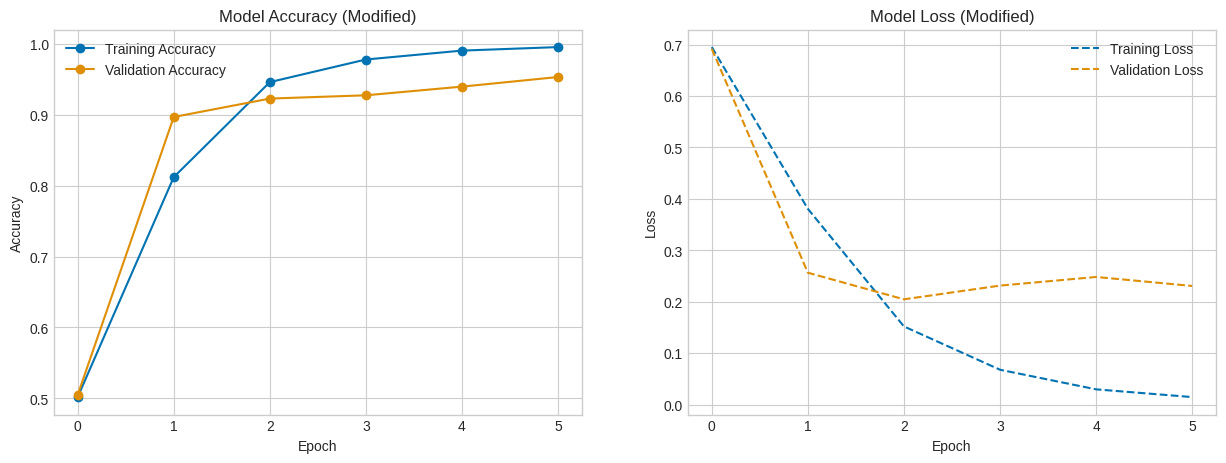

In [48]:
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_modified_transformer.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_modified_transformer.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy (Modified)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_modified_transformer.history['loss'], label='Training Loss', linestyle='--')
plt.plot(history_modified_transformer.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss (Modified)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def get_metrics(model, x, y):
    # Get probabilities and the hard classes
    probs = model.predict(x)
    preds = np.argmax(probs, axis=1)

    # Only need the probability of the "Positive" class for AUC-ROC
    pos_probs = probs[:, 1]

    return [
        accuracy_score(y, preds),
        precision_score(y, preds),
        recall_score(y, preds),
        f1_score(y, preds),
        roc_auc_score(y, pos_probs)
    ]

metrics_basic = get_metrics(model_basic_transformer, x_test, y_test)
metrics_modified = get_metrics(model_modified_transformer, x_test, y_test)

# 2. Display as a nice Table
columns = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]
df_compare = pd.DataFrame([metrics_basic, metrics_modified],
                          columns=columns,
                          index=["Original Model", "Modified Model"])

print(df_compare.round(4))

776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 943us/step
                Accuracy  Precision  Recall  F1-Score  AUC-ROC
Original Model    0.8405     0.8682  0.8040    0.8349   0.9192
Modified Model    0.8343     0.8499  0.8132    0.8312   0.9170
